Importing libraries and configuring SVD and NeuMF

In [ ]:
# neu_mf.py
import os
import random
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load and prepare data
movies = pd.read_csv('movies_ml100k.csv')
ratings = pd.read_csv('ratings_ml100k.csv')
data = pd.merge(ratings, movies, on="movieId")

# Map IDs to consecutive indices
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()
user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
movie_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
idx_to_movie = {i: mid for mid, i in movie_to_idx.items()}

data['user_idx'] = data['userId'].map(user_to_idx)
data['movie_idx'] = data['movieId'].map(movie_to_idx)

# Config
SEED = 42
BATCH_SIZE = 1024
EMBED_DIM = 32
MLP_LAYERS = [64, 32, 16]
NUM_NEGATIVES = 4
EPOCHS = 10
LR = 1e-3
WEIGHT_DECAY = 1e-5
TOP_K = [5, 10, 20]
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Creating User-User, Item-Item and SVD based CF

In [ ]:

# Initialize collaborative filtering models
sparse_matrix = csr_matrix(
    (data['rating'], (data['user_idx'], data['movie_idx'])),
    shape=(len(user_ids), len(movie_ids))
)

user_model = NearestNeighbors(metric='cosine', algorithm='brute').fit(sparse_matrix)
item_model = NearestNeighbors(metric='cosine', algorithm='brute').fit(sparse_matrix.T)

# SVD decomposition
k = 10
U, s, Vt = svds(sparse_matrix.astype(np.float64), k=k)
user_factors = np.dot(U, np.diag(s))
item_factors = Vt.T

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=32, mlp_layers=[64, 32, 16]):
        super(NeuMF, self).__init__()
        
        self.gmf_user_emb = nn.Embedding(num_users, embed_dim)
        self.gmf_item_emb = nn.Embedding(num_items, embed_dim)
        self.mlp_user_emb = nn.Embedding(num_users, embed_dim)
        self.mlp_item_emb = nn.Embedding(num_items, embed_dim)
        
        mlp_modules = []
        input_dim = embed_dim * 2
        for dim in mlp_layers:
            mlp_modules.append(nn.Linear(input_dim, dim))
            mlp_modules.append(nn.ReLU())
            input_dim = dim
        self.mlp_layers = nn.Sequential(*mlp_modules)
        
        self.predict_layer = nn.Linear(embed_dim + mlp_layers[-1], 1)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.gmf_user_emb.weight, std=0.01)
        nn.init.normal_(self.gmf_item_emb.weight, std=0.01)
        nn.init.normal_(self.mlp_user_emb.weight, std=0.01)
        nn.init.normal_(self.mlp_item_emb.weight, std=0.01)
        for m in self.mlp_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        nn.init.xavier_uniform_(self.predict_layer.weight)

    def forward(self, user, item):
        gmf_user = self.gmf_user_emb(user)
        gmf_item = self.gmf_item_emb(item)
        gmf_output = gmf_user * gmf_item
        
        mlp_user = self.mlp_user_emb(user)
        mlp_item = self.mlp_item_emb(item)
        mlp_input = torch.cat((mlp_user, mlp_item), dim=-1)
        mlp_output = self.mlp_layers(mlp_input)
        
        concat = torch.cat((gmf_output, mlp_output), dim=-1)
        output = torch.sigmoid(self.predict_layer(concat)).squeeze(-1)
        return output

def recommend_user_based(user_id, n=10):
    if user_id not in user_to_idx:
        return []
    
    uid = user_to_idx[user_id]
    distances, indices = user_model.kneighbors(sparse_matrix[uid].reshape(1, -1), n_neighbors=20)
    similarities = 1 - distances.flatten()
    rated_movies = sparse_matrix[uid].nonzero()[1]
    
    scores = {}
    for sim, neighbor_idx in zip(similarities, indices.flatten()):
        if neighbor_idx == uid:
            continue
        neighbor_ratings = sparse_matrix[neighbor_idx].tocoo()
        for m_idx, rating in zip(neighbor_ratings.col, neighbor_ratings.data):
            if m_idx not in rated_movies:
                scores[m_idx] = scores.get(m_idx, 0) + sim * rating
    
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]

def recommend_item_based(user_id, n=10):
    if user_id not in user_to_idx:
        return []
    
    uid = user_to_idx[user_id]
    user_ratings = sparse_matrix[uid].tocoo()
    rated_movies = set(user_ratings.col)
    scores = {}

    for m_idx, rating in zip(user_ratings.col, user_ratings.data):
        distances, indices = item_model.kneighbors(sparse_matrix.T[m_idx], n_neighbors=20)
        sims = 1 - distances.flatten()
        
        for sim, sim_m_idx in zip(sims, indices.flatten()):
            if sim_m_idx not in rated_movies:
                scores[sim_m_idx] = scores.get(sim_m_idx, 0) + sim * rating
    
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]

def recommend_svd(user_id, n=10):
    if user_id not in user_to_idx:
        return []
    
    uid = user_to_idx[user_id]
    scores = np.dot(item_factors, user_factors[uid])
    rated_movies = sparse_matrix[uid].nonzero()[1]
    scores[rated_movies] = -np.inf
    
    top_indices = np.argpartition(scores, -n)[-n:]
    top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]
    return [(idx, scores[idx]) for idx in top_indices]

def recommend_neumf(model, user_id, n=10):
    if user_id not in user_to_idx:
        return []
    
    uid = user_to_idx[user_id]
    rated_movies = sparse_matrix[uid].nonzero()[1]
    
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([uid] * len(movie_ids), device=DEVICE)
        item_tensor = torch.tensor(list(range(len(movie_ids))), device=DEVICE)
        scores = model(user_tensor, item_tensor).cpu().numpy()
    
    scores[rated_movies] = -np.inf
    top_indices = np.argpartition(scores, -n)[-n:]
    top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]
    return [(idx, scores[idx]) for idx in top_indices]

def recommend_movies(user_id, N=10, neumf_model=None):
    recommendations = {}
    
    # Get recommendations from all methods
    user_recs = recommend_user_based(user_id, N)
    item_recs = recommend_item_based(user_id, N)
    svd_recs = recommend_svd(user_id, N)
    
    recommendations['user_based'] = process_recommendations(user_recs)
    recommendations['item_based'] = process_recommendations(item_recs)
    recommendations['svd'] = process_recommendations(svd_recs)
    
    if neumf_model is not None:
        neumf_recs = recommend_neumf(neumf_model, user_id, N)
        recommendations['neumf'] = process_recommendations(neumf_recs)
    
    # Combined recommendations (simple union)
    all_recs = {}
    for method, recs in recommendations.items():
        for movie in recs:
            movie_id = movie['movieId']
            if movie_id not in all_recs:
                all_recs[movie_id] = movie
                all_recs[movie_id]['methods'] = [method]
                all_recs[movie_id]['score'] = movie['score']
            else:
                all_recs[movie_id]['methods'].append(method)
                all_recs[movie_id]['score'] += movie['score']
    
    combined = sorted(all_recs.values(), key=lambda x: x['score'], reverse=True)[:N]
    recommendations['combined'] = combined
    
    return recommendations

def process_recommendations(recs):
    return [
        {
            'movieId': idx_to_movie[movie_idx],
            'score': score,
            'title': movies[movies['movieId'] == idx_to_movie[movie_idx]]['title'].iloc[0] 
            if idx_to_movie[movie_idx] in movies['movieId'].values else 'Unknown'
        }
        for movie_idx, score in recs
    ]

# Evaluation functions
def precision_at_k(recommended, relevant, k):
    recommended_k = [r[0] for r in recommended[:k]]
    if not recommended_k:
        return 0.0
    return len(set(recommended_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    recommended_k = [r[0] for r in recommended[:k]]
    if not relevant:
        return 0.0
    return len(set(recommended_k) & set(relevant)) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    recommended_k = [r[0] for r in recommended[:k]]
    dcg = 0.0
    for i, rec in enumerate(recommended_k):
        if rec in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_model(model_func, test_data, k_values=[5, 10]):
    precision_scores = {k: [] for k in k_values}
    recall_scores = {k: [] for k in k_values}
    ndcg_scores = {k: [] for k in k_values}

    for user_id in test_data['userId'].unique():
        if user_id not in user_to_idx:
            continue
        uid = user_to_idx[user_id]
        
        relevant = test_data[test_data['userId'] == user_id]['movie_idx'].tolist()
        if not relevant:
            continue

        recommended = model_func(user_id, max(k_values))
        if not recommended:
            continue

        for k in k_values:
            precision_scores[k].append(precision_at_k(recommended, relevant, k))
            recall_scores[k].append(recall_at_k(recommended, relevant, k))
            ndcg_scores[k].append(ndcg_at_k(recommended, relevant, k))

    return (
        {k: np.mean(precision_scores[k]) for k in k_values},
        {k: np.mean(recall_scores[k]) for k in k_values},
        {k: np.mean(ndcg_scores[k]) for k in k_values}
    )

def evaluate_all_models(test_data, neumf_model=None, k_values=[5, 10]):
    models = {
        'user_based': recommend_user_based,
        'item_based': recommend_item_based,
        'svd': recommend_svd,
    }
    
    if neumf_model is not None:
        models['neumf'] = lambda user_id, n: recommend_neumf(neumf_model, user_id, n)
    
    results = {}
    
    for name, model_func in models.items():
        print(f"Evaluating {name}...")
        precision, recall, ndcg = evaluate_model(model_func, test_data, k_values)
        results[name] = {
            'precision': precision,
            'recall': recall,
            'ndcg': ndcg
        }
    
    return results

def plot_model_comparison_k10(results, save_path="ModelCompK10.png"):
    """Create ModelCompK10.png - Model comparison at K=10"""
    plt.figure(figsize=(12, 8))
    
    models = list(results.keys())
    metrics = ['precision', 'recall', 'ndcg']
    
    # Data for K=10
    k10_data = {}
    for model in models:
        k10_data[model] = {
            'precision': results[model]['precision'][10],
            'recall': results[model]['recall'][10], 
            'ndcg': results[model]['ndcg'][10]
        }
    
    # Create grouped bar chart
    x = np.arange(len(models))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, metric in enumerate(metrics):
        values = [k10_data[model][metric] for model in models]
        ax.bar(x + i * width, values, width, label=metric.capitalize(), alpha=0.8)
    
    ax.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax.set_ylabel('Scores', fontsize=14, fontweight='bold')
    ax.set_title('Model Performance Comparison at K=10', fontsize=16, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels([model.upper() for model in models], fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, model in enumerate(models):
        for j, metric in enumerate(metrics):
            value = k10_data[model][metric]
            ax.text(i + j * width, value + 0.01, f'{value:.3f}', 
                   ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved model comparison plot as {save_path}")

def plot_performance_radar(results, save_path="performance.png"):
    """Create performance.png - Radar chart comparing all models"""
    plt.figure(figsize=(10, 10))
    
    models = list(results.keys())
    metrics = ['precision', 'recall', 'ndcg']
    
    # Angles for radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    for idx, model in enumerate(models):
        values = [results[model][metric][10] for metric in metrics]  # Using K=10
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model.upper(), color=colors[idx])
        ax.fill(angles, values, alpha=0.1, color=colors[idx])
    
    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.upper() for m in metrics], fontsize=12)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=12)
    plt.title('Model Performance Radar Chart (K=10)', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved performance radar chart as {save_path}")

def plot_metrics_comparison(results, k_values, metric_name):
    """Plot metric comparison across different K values"""
    plt.figure(figsize=(10, 6))
    
    models = list(results.keys())
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for i, model in enumerate(models):
        if model in results:
            metric_values = [results[model][metric_name][k] for k in k_values]
            plt.plot(k_values, metric_values, marker='o', label=model, 
                    color=colors[i % len(colors)], linewidth=2, markersize=8)
    
    plt.title(f'{metric_name.upper()}@K Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('K', fontsize=12)
    plt.ylabel(metric_name.capitalize(), fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.show()

# Training functions for NeuMF
class NeuMFDataset(Dataset):
    def __init__(self, train_df, num_items, num_negatives=4, user_pos_dict=None):
        self.num_negatives = num_negatives
        self.num_items = num_items
        
        pos_data = train_df[train_df['label'] == 1][['user_idx', 'item_idx']]
        self.users = pos_data['user_idx'].values.astype('int32')
        self.items = pos_data['item_idx'].values.astype('int32')
        self.length = len(self.users)
        
        if user_pos_dict is None:
            self.user_pos = defaultdict(set)
            for u, i in pos_data.values:
                self.user_pos[u].add(i)
        else:
            self.user_pos = user_pos_dict

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        user = self.users[idx]
        pos_item = self.items[idx]
        
        user_seen = self.user_pos.get(user, set())
        candidate_negatives = list(set(range(self.num_items)) - user_seen)
        
        if len(candidate_negatives) >= self.num_negatives:
            neg_items = np.random.choice(candidate_negatives, size=self.num_negatives, replace=False)
        else:
            neg_items = np.random.choice(candidate_negatives, size=self.num_negatives, replace=True)
        
        batch_users = np.concatenate([[user], [user] * self.num_negatives])
        batch_items = np.concatenate([[pos_item], neg_items])
        batch_labels = np.concatenate([[1.0], [0.0] * self.num_negatives])
        
        return (
            torch.from_numpy(batch_users).long(),
            torch.from_numpy(batch_items).long(), 
            torch.from_numpy(batch_labels).float()
        )

def evaluate_neumf(model, test_df, user_pos_dict, num_items, top_k_list=[5, 10, 20], eval_negatives=99):
    model.eval()
    hr, ndcg, precision, recall = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

    with torch.no_grad():
        for user in test_df['user_idx'].unique():
            test_item = test_df[test_df['user_idx'] == user]['item_idx'].values[0]
            
            negatives = np.random.choice(list(set(range(num_items)) - user_pos_dict[user]), size=eval_negatives, replace=False)
            test_items = np.concatenate(([test_item], negatives))
            users = np.full(len(test_items), user, dtype=np.int64)

            user_tensor = torch.tensor(users, device=DEVICE)
            item_tensor = torch.tensor(test_items, device=DEVICE)
            scores = model(user_tensor, item_tensor).cpu().numpy()
            
            rank_indices = np.argsort(-scores)
            ranked_items = test_items[rank_indices]

            for k in top_k_list:
                top_k_items = ranked_items[:k]
                hit = int(test_item in top_k_items)
                hr[k].append(hit)
                if hit:
                    rank = np.where(top_k_items == test_item)[0][0]
                    ndcg[k].append(1 / np.log2(rank + 2))
                else:
                    ndcg[k].append(0)
                
                precision[k].append(np.mean([test_item in top_k_items]))
                recall[k].append(hit)
    
    metrics = {}
    for k in top_k_list:
        metrics[f'hr_{k}'] = np.mean(hr[k])
        metrics[f'ndcg_{k}'] = np.mean(ndcg[k])
        metrics[f'precision_{k}'] = np.mean(precision[k])
        metrics[f'recall_{k}'] = np.mean(recall[k])
    
    return metrics

def train_neumf(model, train_loader, test_df, user_pos_dict, optimizer, criterion, epochs=10):
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for users, items, labels in train_loader:
            users = users.view(-1).to(DEVICE)
            items = items.view(-1).to(DEVICE)
            labels = labels.view(-1).to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(users, items)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        
        if epoch % 5 == 0:
            eval_metrics = evaluate_neumf(model, test_df, user_pos_dict, model.gmf_item_emb.num_embeddings)
            print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f} - HR@10: {eval_metrics['hr_10']:.4f}")

def make_mappings(df):
    unique_users = df['userId'].unique()
    unique_items = df['movieId'].unique()
    
    user_to_idx = {u: i for i, u in enumerate(unique_users)}
    item_to_idx = {i: j for j, i in enumerate(unique_items)}
    
    return user_to_idx, item_to_idx, len(unique_users), len(unique_items)

def prepare_train_test(df, user_to_idx, item_to_idx, leave_one_out=True, min_positive=2):
    df = df.copy()
    df['user_idx'] = df['userId'].map(user_to_idx)
    df['item_idx'] = df['movieId'].map(item_to_idx)
    df = df.dropna(subset=['user_idx', 'item_idx'])
    
    df['label'] = (df['rating'] >= 4).astype('int8')
    
    if leave_one_out:
        user_positive_counts = df[df['label'] == 1].groupby('user_idx').size()
        valid_users = user_positive_counts[user_positive_counts >= min_positive].index
        df = df[df['user_idx'].isin(valid_users)]
        
        test_pos = df[df['label'] == 1].groupby('user_idx').tail(1)
        test_idx = test_pos.index
        train = df.drop(test_idx).copy()
        test = test_pos.copy()
    else:
        train = df.sample(frac=0.8, random_state=SEED)
        test = df.drop(train.index)
        test = test[test['label'] == 1]
    
    return train, test


Making and training NeuMF model

In [15]:
# Create train-test split
all_users = data['userId'].unique()
test_users = np.random.choice(all_users, size=int(0.2 * len(all_users)), replace=False)
train_users = [u for u in all_users if u not in test_users]

# Create train/test splits
train = data[data['userId'].isin(train_users)].copy()
test = data[data['userId'].isin(test_users)].copy()

print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"Train users: {len(train_users)}, Test users: {len(test_users)}")

# Train NeuMF model
df = ratings.copy()
user_to_idx, item_to_idx, num_users, num_items = make_mappings(df)
train_df, test_df = prepare_train_test(df, user_to_idx, item_to_idx)

user_pos_dict = defaultdict(set)
for u, i in train_df[train_df['label'] == 1][['user_idx', 'item_idx']].values:
    user_pos_dict[u].add(i)

train_dataset = NeuMFDataset(train_df, num_items, NUM_NEGATIVES, user_pos_dict)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = NeuMF(num_users, num_items, EMBED_DIM, MLP_LAYERS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.BCELoss()

print("Training NeuMF model...")
train_neumf(model, train_loader, test_df, user_pos_dict, optimizer, criterion, EPOCHS)


Train shape: (81094, 29), Test shape: (18906, 29)
Train users: 755, Test users: 188
Training NeuMF model...
Epoch 5/10 - Loss: 0.3214 - HR@10: 0.6274
Epoch 10/10 - Loss: 0.2899 - HR@10: 0.7282


Evaluation Part

Evaluating user_based...
Evaluating item_based...
Evaluating svd...
Evaluating neumf...


<Figure size 1200x800 with 0 Axes>

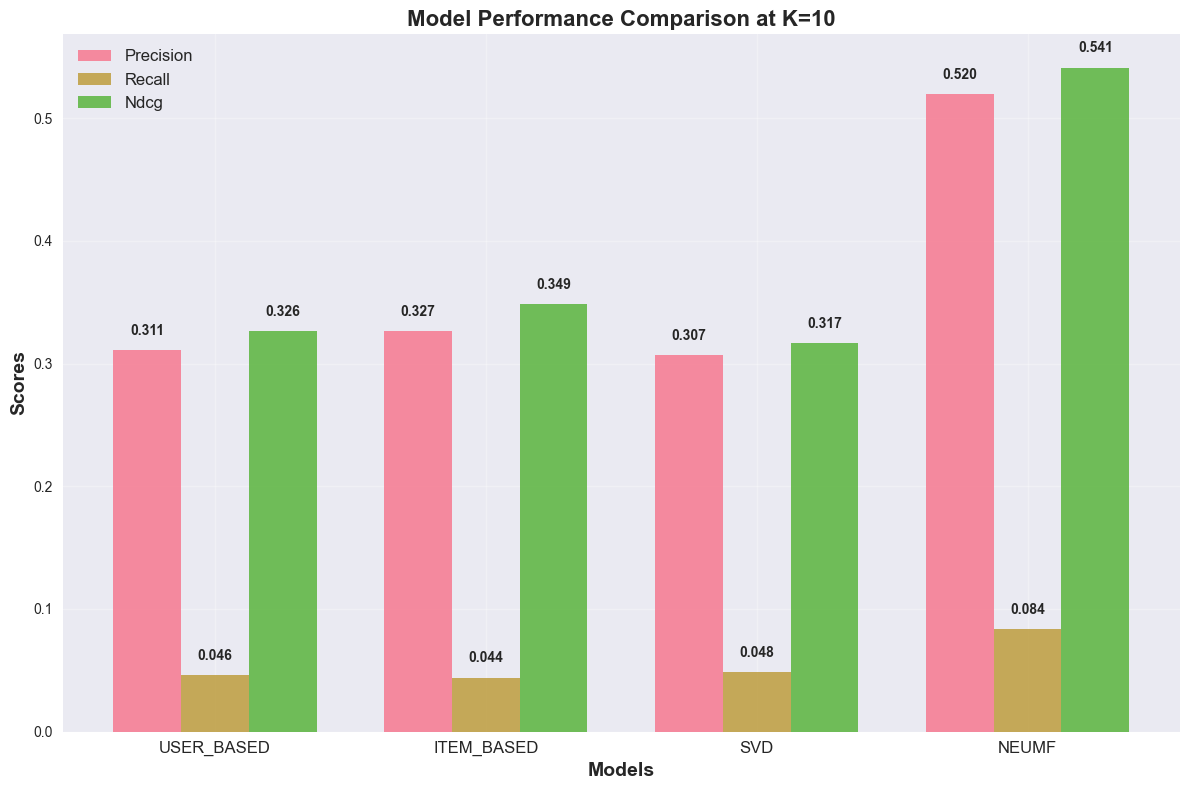

Saved model comparison plot as ModelCompK10.png


<Figure size 1000x1000 with 0 Axes>

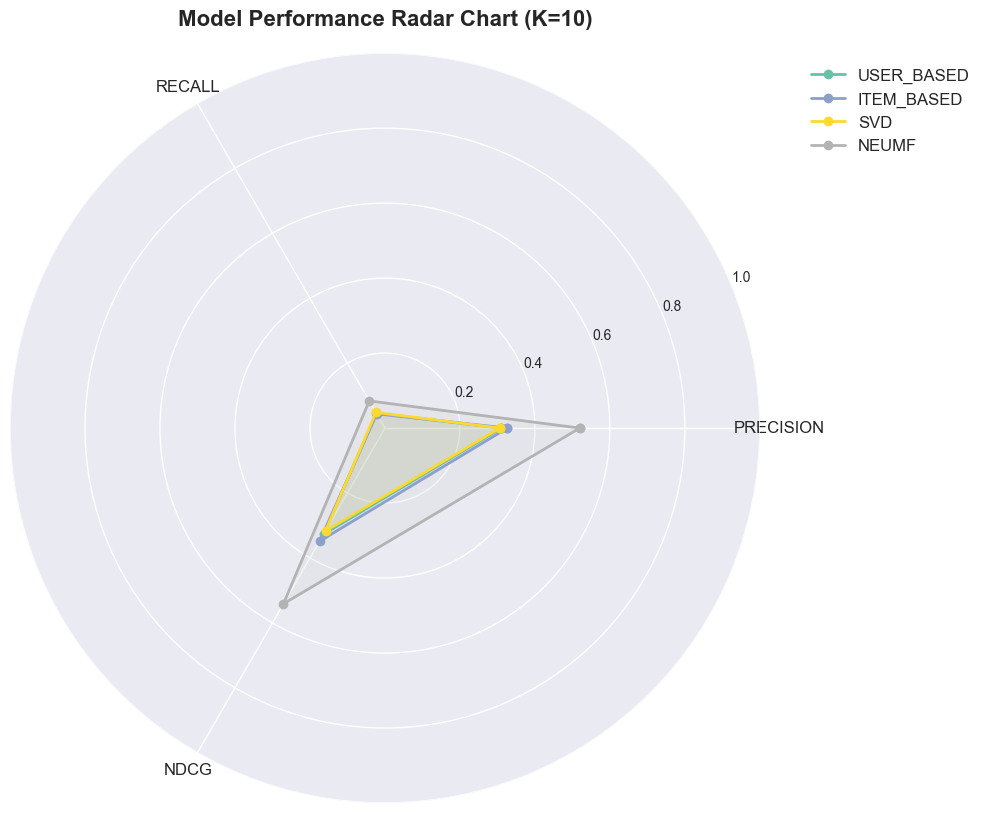

Saved performance radar chart as performance.png

Evaluation Results:

PRECISION@K:
K=5: user_based: 0.3362  item_based: 0.3702  svd: 0.3383  neumf: 0.5628  
K=10: user_based: 0.3106  item_based: 0.3266  svd: 0.3069  neumf: 0.5197  
K=15: user_based: 0.2840  item_based: 0.3103  svd: 0.2830  neumf: 0.4943  
K=20: user_based: 0.2665  item_based: 0.2872  svd: 0.2601  neumf: 0.4729  

RECALL@K:
K=5: user_based: 0.0259  item_based: 0.0258  svd: 0.0281  neumf: 0.0488  
K=10: user_based: 0.0458  item_based: 0.0439  svd: 0.0482  neumf: 0.0836  
K=15: user_based: 0.0614  item_based: 0.0596  svd: 0.0646  neumf: 0.1178  
K=20: user_based: 0.0764  item_based: 0.0738  svd: 0.0765  neumf: 0.1453  

NDCG@K:
K=5: user_based: 0.3479  item_based: 0.3837  svd: 0.3387  neumf: 0.5761  
K=10: user_based: 0.3264  item_based: 0.3485  svd: 0.3165  neumf: 0.5412  
K=15: user_based: 0.3052  item_based: 0.3326  svd: 0.2980  neumf: 0.5195  
K=20: user_based: 0.2899  item_based: 0.3134  svd: 0.2803  neumf: 0.5010  

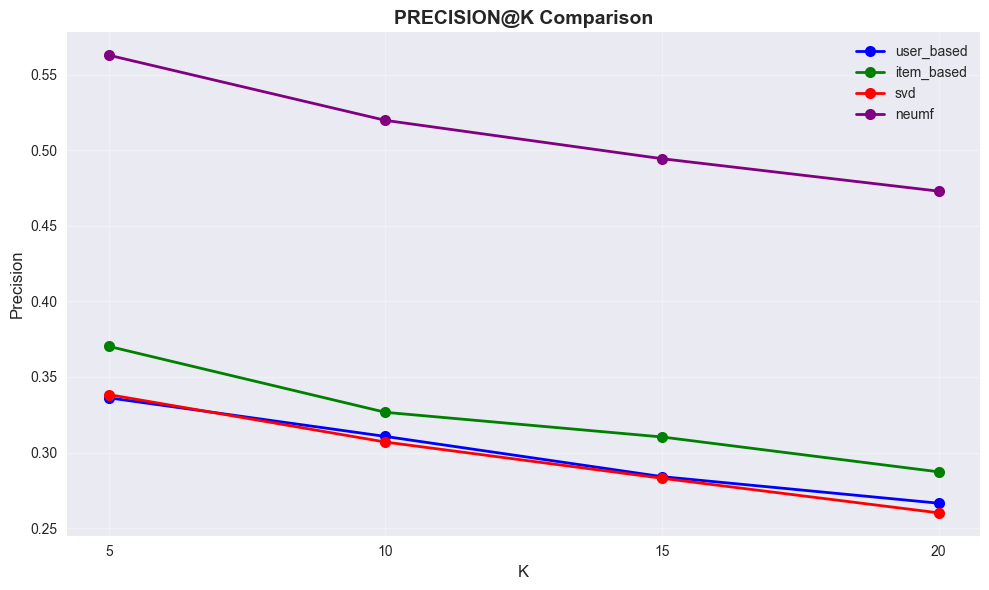

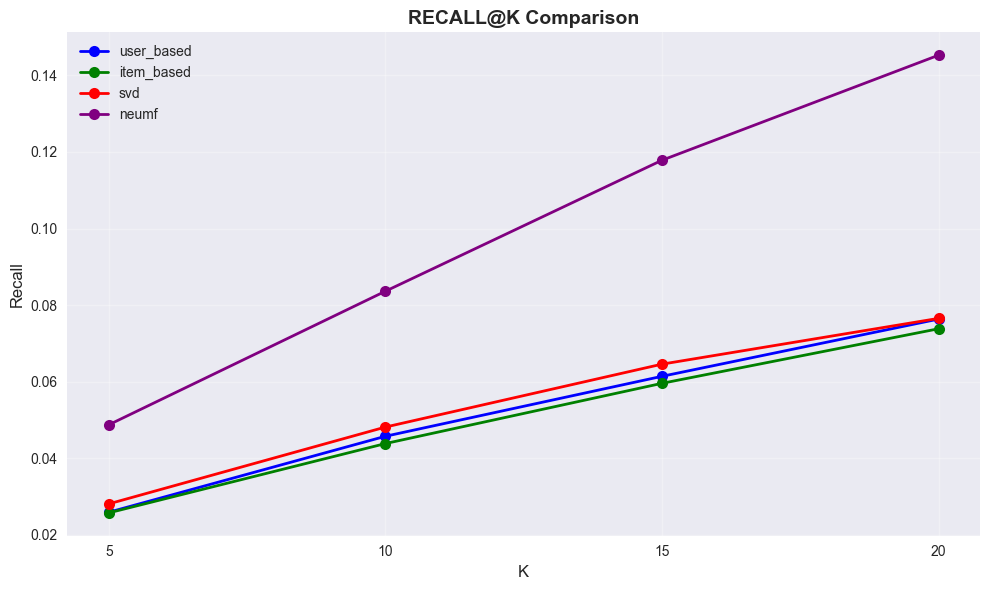

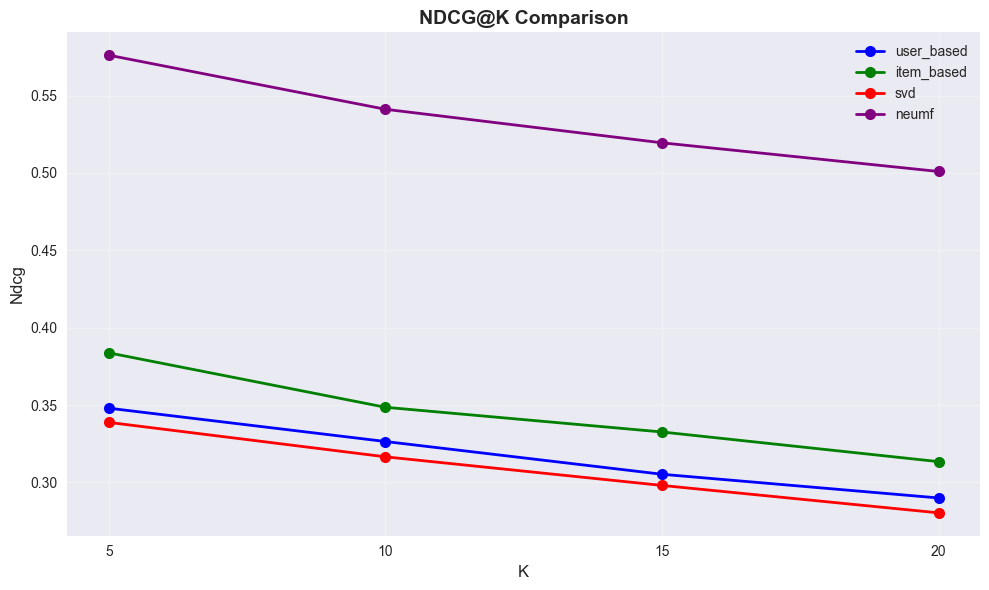

In [16]:

# Evaluate all models
k_values = [5, 10, 15, 20]
results = evaluate_all_models(test, model, k_values)

# Generate the specific plots you asked for
plot_model_comparison_k10(results, "ModelCompK10.png")
plot_performance_radar(results, "performance.png")

# Print results
print("\nEvaluation Results:")
for metric in ['precision', 'recall', 'ndcg']:
    print(f"\n{metric.upper()}@K:")
    for k in k_values:
        print(f"K={k}: ", end="")
        for model_name in results.keys():
            value = results[model_name][metric][k]
            print(f"{model_name}: {value:.4f}  ", end="")
        print()

# Generate additional comparison plots
for metric in ['precision', 'recall', 'ndcg']:
    plot_metrics_comparison(results, k_values, metric)


Using the recommendation system

In [17]:

# Example recommendations
sample_user = test['userId'].iloc[50]
print(f"\nRecommendations for User {sample_user}:")
recommendations = recommend_movies(sample_user, N=5, neumf_model=model)

for method, recs in recommendations.items():
    print(f"\n{method.upper()}:")
    for i, movie in enumerate(recs, 1):
        print(f"{i}. {movie['title']} (Score: {movie['score']:.4f})")


Recommendations for User 561:

USER_BASED:
1. Braveheart (1995) (Score: 121.0104)
2. Stand by Me (1986) (Score: 38.1460)
3. Contact (1997) (Score: 37.1866)
4. Field of Dreams (1989) (Score: 72.3518)
5. Titanic (1997) (Score: 29.3310)

ITEM_BASED:
1. Braveheart (1995) (Score: 70.0133)
2. Stargate (1994) (Score: 43.3236)
3. Amadeus (1984) (Score: 38.7161)
4. Field of Dreams (1989) (Score: 35.6154)
5. Raising Arizona (1987) (Score: 34.0395)

SVD:
1. Braveheart (1995) (Score: 4.8599)
2. Godfather: Part II, The (1974) (Score: 3.2326)
3. Full Metal Jacket (1987) (Score: 2.8959)
4. Field of Dreams (1989) (Score: 2.7594)
5. Tombstone (1993) (Score: 2.6942)

NEUMF:
1. One Flew Over the Cuckoo's Nest (1975) (Score: 0.8603)
2. Amadeus (1984) (Score: 0.8544)
3. Rear Window (1954) (Score: 0.8505)
4. Vertigo (1958) (Score: 0.8155)
5. Wizard of Oz, The (1939) (Score: 0.8043)

COMBINED:
1. Braveheart (1995) (Score: 121.0104)
2. Field of Dreams (1989) (Score: 72.3518)
3. Stargate (1994) (Score: 43.323